## Imports

In [43]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from agentnet.agent import Recurrence

## Data Generator

In [4]:
def generator(t = np.linspace(0,5*np.pi),p = 5,noize = 0.2):
    
    
    while True:
        
        x_prev = (np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[:,None] )+\
                 np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[None,:])) *\
                 np.sin(t[0])
            
        for t_i in t[1:]:
            x_new = (np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[:,None] )+\
                 np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[None,:])) *\
                 np.sin(t_i)

            n = np.random.normal(scale = noize,size = x_prev.shape)
                
            yield x_prev+n, x_new

            x_prev= x_new
        
        n = np.random.normal(scale = noize,size = x_prev.shape)
        yield x_new+n, x_prev

        


### Test Data

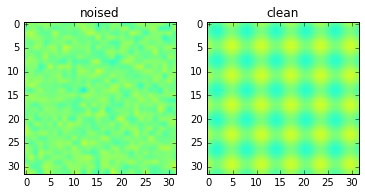

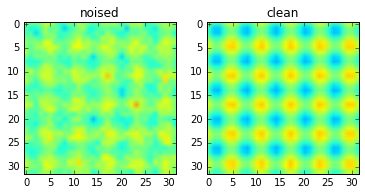

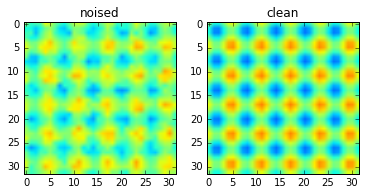

In [42]:
gen = generator()
for i in range(3):
    x,y = gen.next()
    plt.subplot(121)
    plt.imshow(x,vmin=-3,vmax=3)
    plt.title('noised')
    plt.subplot(122)
    plt.imshow(y,vmin=-3,vmax=3)
    plt.title('clean')
    plt.show()


### Network Structure

In [62]:
# create a  defualt 4d tensor
X_seq_inp = T.tensor4()
# add "1" dimension (3rd)
X_seq = X_seq_inp[:,:,None,:,:]

# InputLayer
# @params([?batch size,input in recurrent part size (can be None),1, x_dim_size, y_dim_size]..)
X_seq_layer = InputLayer([None,None,1,32,32],input_var=X_seq,name='seq_of_inputs')

In [63]:
# initial input for generative part of NN
generator_init_var = T.tensor4()
# None - ?
generator_init = InputLayer([None,1,32,32],generator_init_var,name='generator_init')

In [64]:
# batch size to know input size for gen part
gen_batch_size = theano.shared(1)

In [65]:
###########################
# Recurrent part of NN
##########################

#hidden neurons per pixel

def build_recurrence(X_seq_layer,n_hidden = 8,generator_init=generator_init):

    Xi_inp = InputLayer([None,1,32,32],name='x_i')
    
    H_prev = InputLayer([None,n_hidden,32,32],name='hidden prev')


    crnn_from_inp = Conv2DLayer(Xi_inp,num_filters=n_hidden,filter_size=[5,5],#arbitrary
                                b = None,#only apply bias once in from_hid
                                nonlinearity=None,pad='same',name='conv rnn input')
    
    
    crnn_from_hid = Conv2DLayer(H_prev,num_filters=n_hidden,filter_size=[3,3], #arbitrary
                                nonlinearity=None,pad='same',
                                name ='conv rnn hid to hid')


    crnn_sum = ElemwiseSumLayer([crnn_from_hid,crnn_from_inp])



    crnn_new = NonlinearityLayer(crnn_sum, lasagne.nonlinearities.elu)
    
    crnn_out = Conv2DLayer(crnn_new,num_filters=1,filter_size=[3,3],#arbitrary
                                nonlinearity=None, #!!! if precip.rate >0, use ReLU or similar
                                pad='same',
                                name ='conv rnn to prediction',)



    mem_dict = {crnn_new: H_prev}
    
    
    crnn_rec = Recurrence(input_sequences={Xi_inp:X_seq_layer},
                          tracked_outputs = crnn_out,
                         state_variables = mem_dict,
                         n_steps = 15)
    
    from collections import OrderedDict
    mem_dict_generator = OrderedDict([(crnn_new, H_prev),
                                      (crnn_out,Xi_inp)])
    
    #first state
    state_init_gen = {crnn_out:generator_init}
    
    crnn_gen = Recurrence(
                          tracked_outputs = crnn_out,
                         state_variables = mem_dict_generator,
                         n_steps = 20,batch_size=gen_batch_size,
                        state_init = state_init_gen)

    return crnn_rec,crnn_gen, crnn_out,crnn_new


In [66]:
# rec -- recurrence
# rec_generator -- 
# nn_out -- out of conv2dlayer
# nn_new -- nonlinearity output
rec,rec_generator,nn_out,nn_new = build_recurrence(X_seq_layer=X_seq_layer)

In [67]:
# get layers generated hidden_output and prediction  
states, outputs = rec.get_sequence_layers()

In [68]:
#sequence of hidden crnn states
hidden_state_seq_layer = states[nn_new]

#sequence of predictions
pred_y_seq_layer = outputs[0]

In [69]:
#[none, n_steps, 1,32,32]
pred_y_seq = lasagne.layers.get_output(pred_y_seq_layer)

#get rid of "1": [none,n_steps,32,32]
pred_y_seq=pred_y_seq[:,:,0,]

In [70]:
#[none,n_steps,32,32]
Y_seq = T.tensor4()


mse = lasagne.objectives.squared_error(Y_seq,pred_y_seq).mean()
weights = lasagne.layers.get_all_params(pred_y_seq_layer,trainable=True)
updates = lasagne.updates.adamax(mse,weights)

In [71]:
import theano
f = theano.function([X_seq_inp,Y_seq], mse, updates=updates)

In [72]:
losses = []
for epoch in range(1000):
    
    x_batch, y_batch = zip(*[ gen.next() for i in range(15)])
    x_batch = np.stack(x_batch)[None,:].astype('float32')
    y_batch = np.stack(y_batch)[None,:].astype('float32')
    losses.append( f(x_batch,y_batch))
    if epoch%100==0:
        print "epoch:",epoch
    

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900


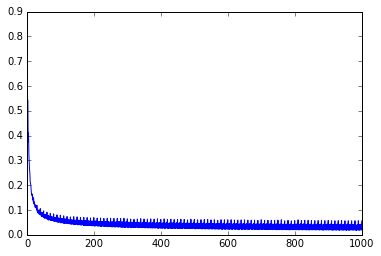

In [73]:
plt.plot(losses)

In [19]:
pred_1_step = theano.function([X_seq_inp],pred_y_seq)

In [36]:
y_batch[0][1]

array([[ -7.32474123e-16,  -5.07583082e-01,  -5.36986351e-01, ...,
          5.36986351e-01,   5.07583082e-01,   0.00000000e+00],
       [ -5.07583082e-01,  -1.01516616e+00,  -1.04456937e+00, ...,
          2.94032823e-02,  -5.97632460e-16,  -5.07583082e-01],
       [ -5.36986351e-01,  -1.04456937e+00,  -1.07397270e+00, ...,
          4.64825265e-16,  -2.94032823e-02,  -5.36986351e-01],
       ..., 
       [  5.36986351e-01,   2.94032823e-02,   4.64825265e-16, ...,
          1.07397270e+00,   1.04456937e+00,   5.36986351e-01],
       [  5.07583082e-01,  -5.97632460e-16,  -2.94032823e-02, ...,
          1.04456937e+00,   1.01516616e+00,   5.07583082e-01],
       [  0.00000000e+00,  -5.07583082e-01,  -5.36986351e-01, ...,
          5.36986351e-01,   5.07583082e-01,   7.32474123e-16]], dtype=float32)

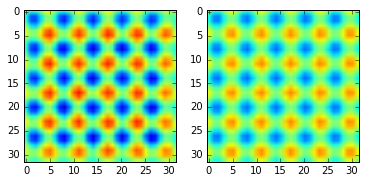

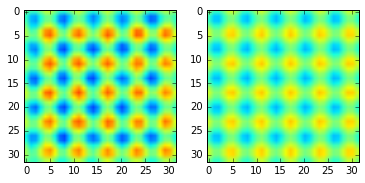

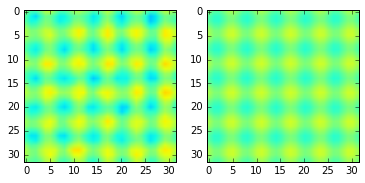

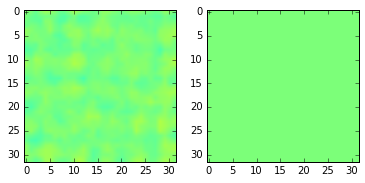

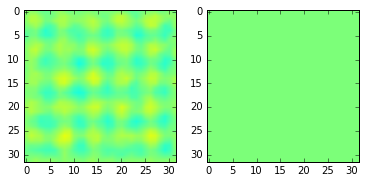

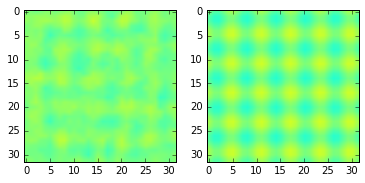

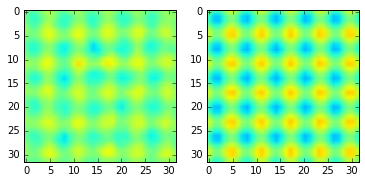

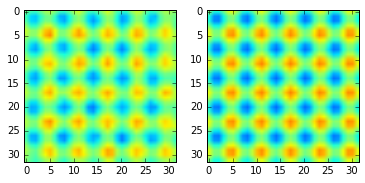

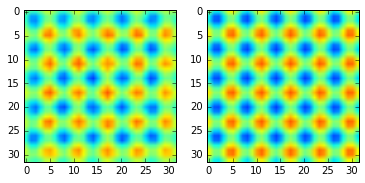

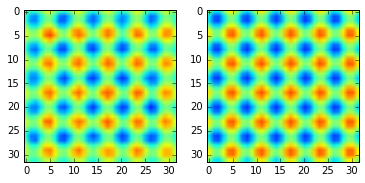

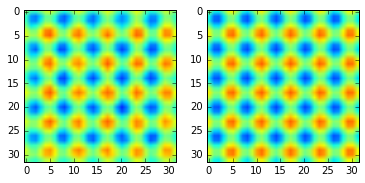

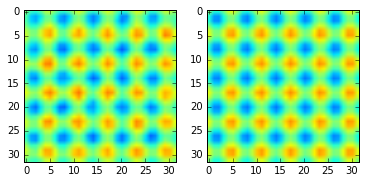

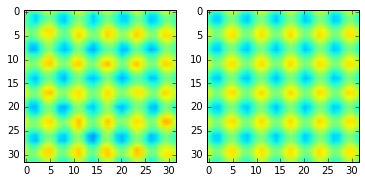

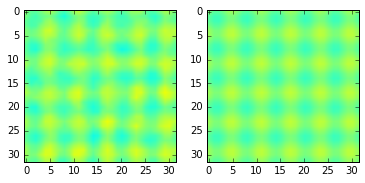

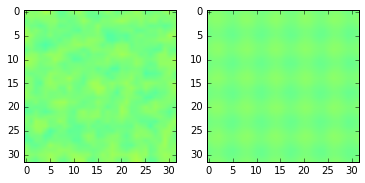

In [37]:
for i, img in enumerate(pred_1_step(x_batch)[0]):
    plt.subplot(121)
    plt.imshow(img,vmin=-3,vmax=3)
    plt.subplot(122)
    plt.imshow(y_batch[0][i],vmin=-3,vmax=3)
    plt.show()

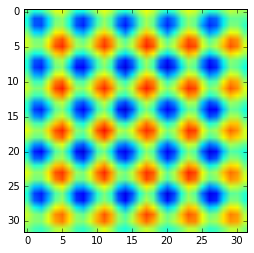

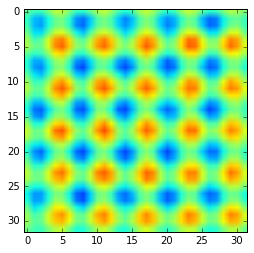

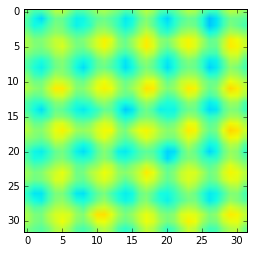

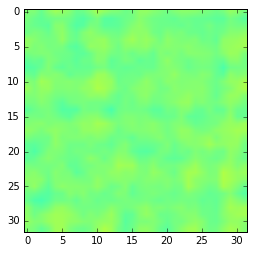

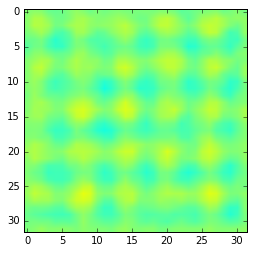

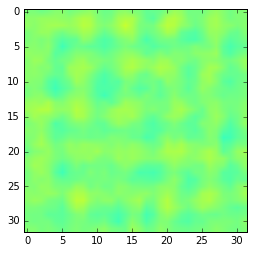

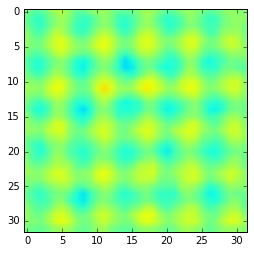

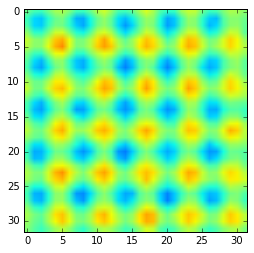

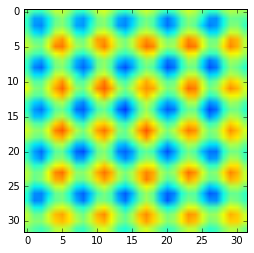

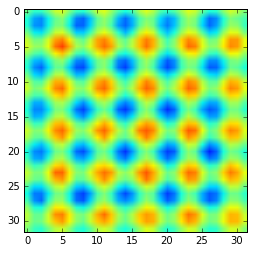

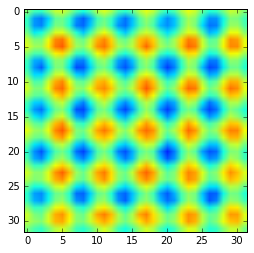

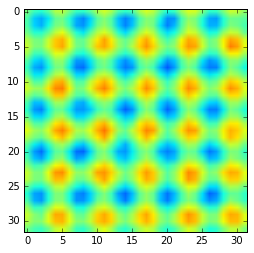

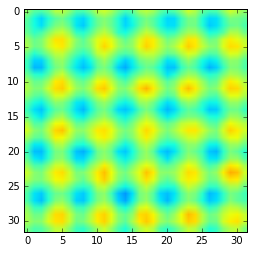

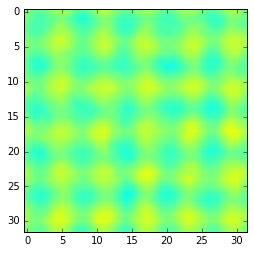

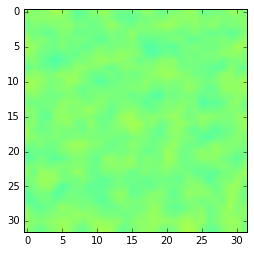

In [24]:
for img in pred_1_step(x_batch)[0]:
    plt.imshow(img,vmin=-3,vmax=3)
    plt.show()

In [23]:
gen_states,gen_outputs = rec_generator.get_sequence_layers()

gen_seq = lasagne.layers.get_output(gen_outputs[0])

generate = theano.function([generator_init_var], gen_seq)

In [24]:
x_batch.shape

(1, 15, 32, 32)

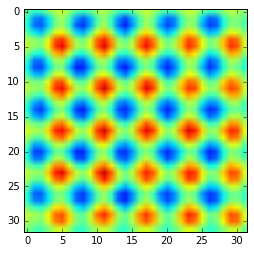

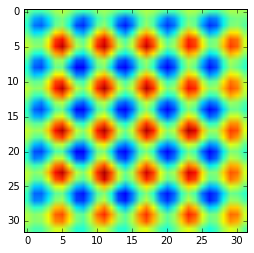

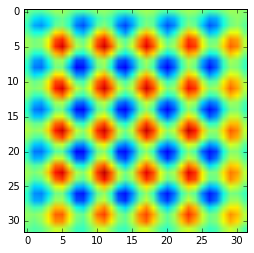

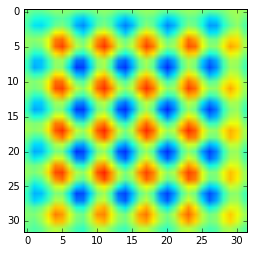

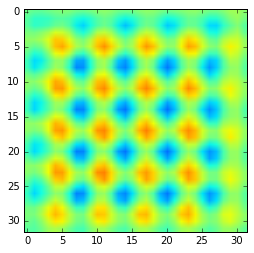

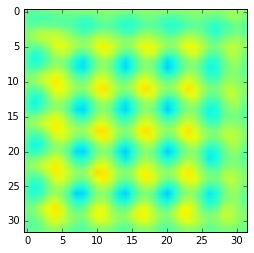

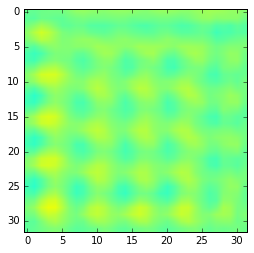

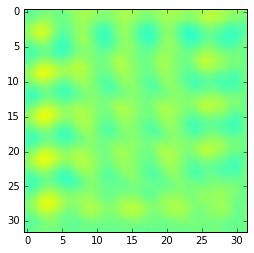

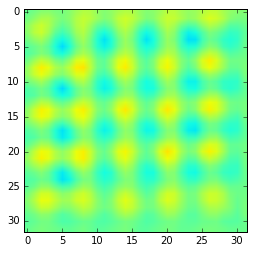

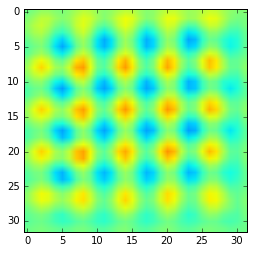

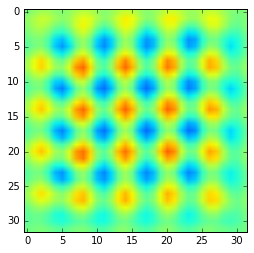

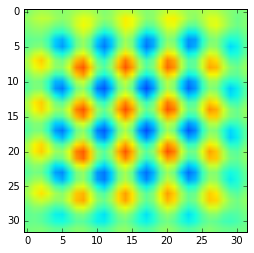

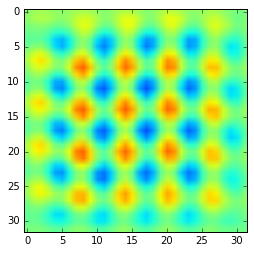

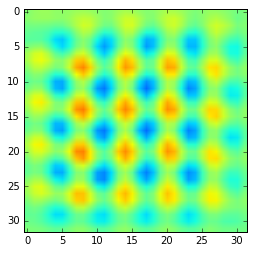

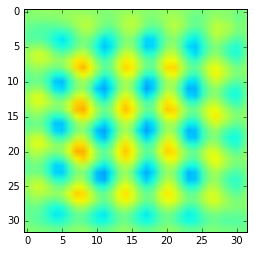

In [25]:
init= x_batch[:,0,None,]
for img in generate(init)[0,:,0]:
    plt.imshow(img,vmin=-3,vmax=3)
    plt.show()